In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install -q imagecorruptions

In [3]:
from utils import *
from utils.losses import SparseCategoricalFocalLoss
from utils.callbacks.cyclicLR import CyclicLR
from utils.tempered_loss import bi_tempered_logistic_loss

In [4]:
loader = DataLoader(
    path_csv='../input/cassava-leaf-disease-classification/cassava_folds.csv',
    path_images='../input/cassava-leaf-disease-classification/train_images/',
    split_method='fold0'
)

print('\nTrain data distribution')
loader.print_data_distribution('train')

print('\nValidation data distribution')
loader.print_data_distribution('val')

Using splitted fold 0...
Class weights: {0: 3.474310915104741, 1: 1.884688995215311, 2: 1.8613112817483757, 3: 0.3294511238891793, 4: 1.6421052631578947}
Total train: 15756, Total val: 5641

Train data distribution
3    60.707032
4    12.179487
2    10.745113
1    10.611830
0     5.756537
Name: label, dtype: float64

Validation data distribution
3    63.694380
2    12.285056
4    11.664598
1     9.165042
0     3.190924
Name: label, dtype: float64


Train data
Batch X:  (4, 456, 456, 3) -2.21809238891261 3.4227696874715763
Batch Y:  (4, 5) 0.0 1.0


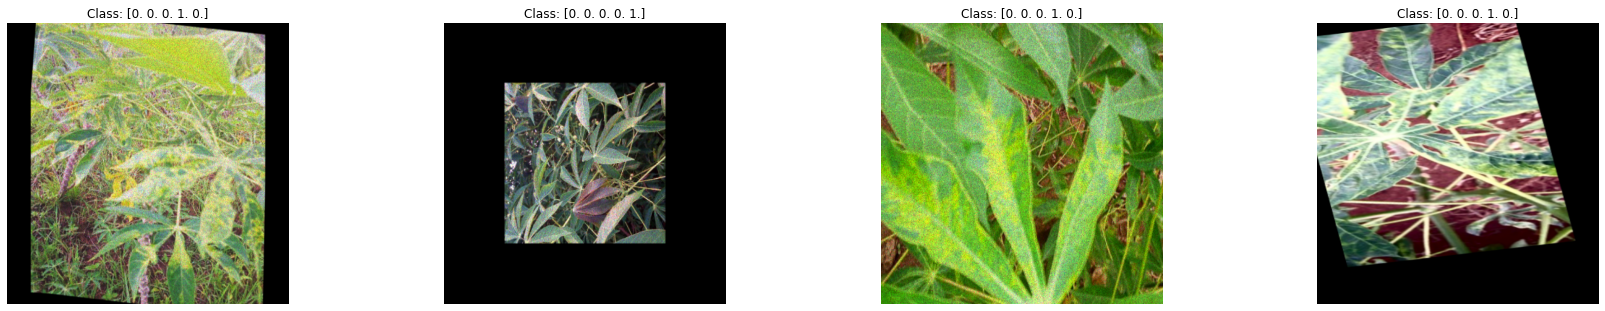

In [5]:
print('Train data')
loader.view_data(data='train', batch_size=4)

Validation data
Batch X:  (4, 456, 456, 3) -2.21809238891261 3.4227696874715763
Batch Y:  (4, 5) 0.0 1.0


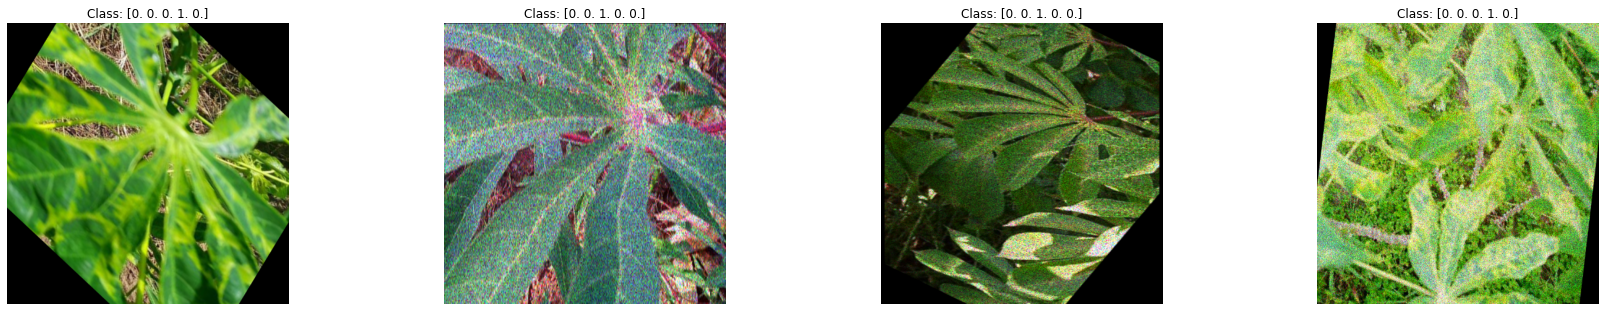

In [6]:
print('Validation data')
loader.view_data(data='val', batch_size=4)

In [7]:
def get_model():
    tf.keras.backend.clear_session()
    
    with tf.distribute.MirroredStrategy().scope():
        # loss function
        def bi_tempered(y_true, y_pred):
            loss = bi_tempered_logistic_loss(y_pred, y_true, 0.5, 1.2, 0.2)
            return tf.reduce_sum(loss)

        class_weight = np.array(list(loader.class_weights.values()))
        gamma = 1./class_weight
        gamma /= gamma.min()
        gamma = np.round(gamma)
        def focal_loss(y_true, y_pred):
            y_true = tf.math.argmax(y_true, axis=-1)
            return SparseCategoricalFocalLoss(
                gamma=gamma,
                reduction=tf.keras.losses.Reduction.NONE,
            ) (y_true, y_pred)

        def loss(y_true, y_pred):
            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.cast(y_pred, tf.float32)
            return focal_loss(y_true, y_pred) + bi_tempered(y_true, y_pred)

        model = Model()
        model.compile(
            tf.keras.optimizers.Adam(lr=0.5e-4, decay=1e-3),
            loss=loss,
            metrics = ['acc']
        )

    return model

## Model fitting

In [ ]:
for fold in range(0,5):
    
    loader = DataLoader(
        path_csv='../input/cassava-leaf-disease-classification/cassava_folds.csv',
        path_images='../input/cassava-leaf-disease-classification/train_images/',
        split_method=f'fold{fold}'
    )
    path_model = f'model_f{fold}.h5'
    model = get_model()
    
    fit_options = dict(
        x=loader.flow('train', batch_size=BATCH_SIZE),
        steps_per_epoch=loader.data_size('train')//BATCH_SIZE,
        validation_data=loader.flow('val', batch_size=BATCH_SIZE),
        validation_steps=loader.data_size('val')//BATCH_SIZE,
        use_multiprocessing=True
    )

    # start training in 2 steps
    model.fit(
        **fit_options,
        epochs=20,
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(path_model, monitor='val_acc', verbose=1, save_best_only=True,
                                               save_weights_only=False, mode='max'),
            tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5, verbose=1, 
                                            mode='max', restore_best_weights=True),
            tf.keras.callbacks.CSVLogger(filename=f'training_log_fold{fold}.csv', separator=',', append=False),
            CyclicLR(base_lr=0.8e-4, max_lr=3e-4, step_size=4*loader.data_size('train')//BATCH_SIZE,
                     mode='exp_range', gamma=0.9)
        ]
    )
    
    model = get_model()
    model.load_weights(path_model)
    model.fit(
        **fit_options,
        epochs=50,
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(path_model, monitor='val_acc', verbose=1, save_best_only=True,
                                               save_weights_only=False, mode='max'),
            tf.keras.callbacks.CSVLogger(filename=f'training_log_fold{fold}.csv', separator=',', append=True),
            tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=1, 
                                            mode='max', restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                                 verbose=1, mode='max', min_lr=1e-8, min_delta=0.01)
        ]
    )

Using splitted fold 0...
Class weights: {0: 3.474310915104741, 1: 1.884688995215311, 2: 1.8613112817483757, 3: 0.3294511238891793, 4: 1.6421052631578947}
Total train: 15756, Total val: 5641
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:local

In [ ]:
model.load_weights('model.h5')

In [ ]:
plot_loss(model.history, '', 0)

In [ ]:
# evaluate model
loader.evaluate(model, mode='categorical', tta=1)

In [ ]:
# evaluate model
loader.evaluate(model, mode='categorical', tta=10)

In [ ]:
loader.create_submission(
    model = model,
    path_to_csv = '../input/cassava-leaf-disease-classification/sample_submission.csv',
    path_to_images = '../input/cassava-leaf-disease-classification/test_images/'
)